In [6]:
import urllib2
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import pylab as pl
%matplotlib inline
plt.rcParams['figure.figsize'] = (13,8)
import random as rand
from collections import Counter
from pandas import DataFrame, read_csv
import pandas as pd
from IPython.display import display
import geoplotlib
from geoplotlib.utils import BoundingBox
from geoplotlib.colors import ColorMap
import pylab as pl
from sklearn import neighbors, datasets, linear_model
from matplotlib.colors import ListedColormap
from operator import itemgetter
import re
from __future__ import division
from mpl_toolkits.mplot3d import Axes3D
import statsmodels.formula.api as sm

**Section 1:** Import dataset and create clean where necessary

In [7]:
#Import dataset as a pandas dataframe

path = "C:/Users/Luisa HP/Google Drive/DTU/02806 Social Data Analysis/Final Project/"
filename = "mydata.csv"
# Read CSV data with Pandas formatting
mydata = pd.read_csv(path+filename)

C:\Users\Luisa HP\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (8,18,19,21,39,44,45,46,47,49,50) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
# Get an impression of the data

mydata[0:2]

Unnamed: 0  Unique Key            Created Date             Closed Date  \
0         471    35525651  02/18/2017 09:17:00 AM  02/21/2017 12:00:00 PM   
1        7515    35172585  01/05/2017 08:21:00 AM  01/06/2017 12:00:00 PM   

  Agency      Agency Name Complaint Type                         Descriptor  \
0   DSNY        A - Bronx           Snow             E9 Snow / Icy Sidewalk   
1   DSNY  BCC - Manhattan           Snow  15S Re-Plow/Spread/Ice-Snow Cond.   

  Location Type  Incident Zip   ...    Bridge Highway Name  \
0      Sidewalk           NaN   ...                    NaN   
1        Street           NaN   ...                    NaN   

  Bridge Highway Direction Road Ramp Bridge Highway Segment Garage Lot Name  \
0                      NaN       NaN                    NaN             NaN   
1                      NaN       NaN                    NaN             NaN   

  Ferry Direction Ferry Terminal Name Latitude Longitude Location  
0             NaN                 NaN      NaN       NaN      NaN  
1             NaN                 NaN      NaN       NaN      NaN  

[2 rows x 54 columns]

In [18]:
# Key info about the data

#print mydata.dtypes
print "\nNo. of rows in dataset:", len(mydata.index)

Unnamed: 0                          int64
Unique Key                          int64
Created Date                       object
Closed Date                        object
Agency                             object
Agency Name                        object
Complaint Type                     object
Descriptor                         object
Location Type                      object
Incident Zip                      float64
Incident Address                   object
Street Name                        object
Cross Street 1                     object
Cross Street 2                     object
Intersection Street 1              object
Intersection Street 2              object
Address Type                       object
City                               object
Landmark                           object
Facility Type                      object
Status                             object
Due Date                           object
Resolution Description             object
Resolution Action Updated Date    

In [19]:
# Dates need to be tranformed to date format

mydata['crea_dates'] = pd.to_datetime(mydata['Created Date'])

In [20]:
# Save data as csv, so it can be used in the future

mydata.to_csv("C:/Users/Luisa HP/Google Drive/DTU/02806 Social Data Analysis/Final Project/mydata_withdates_v2.csv")

In [21]:
# Date range of dataset

print "Min date:", mydata["crea_dates"].min()
print "Max date:", mydata["crea_dates"].max()

Min date: 2010-01-01 00:03:46
Max date: 2017-03-27 01:37:07


In [22]:
# Number of missing observations in crucial columns (location, date, description and type)

missingGeo = mydata[mydata['Latitude'].isnull()]
print "Missing geodata", len(missingGeo)

missingDate = mydata[mydata['Created Date'].isnull()]
print "Missing date", len(missingDate)

missingDesc = mydata[mydata['Descriptor'].isnull()]
print "Missing descriptor", len(missingDesc)

missingType = mydata[mydata['Complaint Type'].isnull()]
print "Missing type", len(missingType)

Missing geodata 28462
Missing date 0
Missing descriptor 31092
Missing type 0


In [23]:
# Create new time variables based on created date

mydata["Year"] = mydata['crea_dates'].dt.year
mydata["Weekday"] = mydata['crea_dates'].dt.weekday
mydata["Hour"] = mydata['crea_dates'].dt.hour
mydata["Weekday_name"] = mydata['crea_dates'].dt.weekday_name

In [24]:
# Create time of day 

mydata = mydata.assign(
    TimeOfDay=pd.cut(
        mydata.Hour,
        [-1, 5, 11, 17, 24],
        labels=['Night', 'Morning', 'Afternoon', 'Evening']))

In [25]:
# Remove data from before 2017, so the data set has a nice end date (Dec 31, 2016)

mydata = mydata[(mydata["Year"] < 2017)]

In [26]:
#Some lat+long data is missing, so we'll remove these observations

mydata = mydata[mydata['Latitude'].notnull()]

**Section 2:** Display basic distributions and maps

In [27]:
# Create one dataframe for each complaint type to analyse each type independently

party = mydata[(mydata.Descriptor == "Loud Music/Party")]
urine = mydata[(mydata["Complaint Type"] == "Urinating in Public")]
rodent = mydata[(mydata["Complaint Type"] == "Rodent")]
graffiti = mydata[(mydata["Complaint Type"] == "Graffiti")]
air = mydata[(mydata["Complaint Type"] == "Air Quality")]

In [28]:
# Find yearly distribution of each complaint type

party_year_dist = pd.DataFrame(party.groupby('Year').size())
rodent_year_dist = pd.DataFrame(rodent.groupby('Year').size())
graffiti_year_dist = pd.DataFrame(graffiti.groupby('Year').size())
air_year_dist = pd.DataFrame(air.groupby('Year').size())
urine_year_dist = pd.DataFrame(urine.groupby('Year').size())

In [32]:
# Print distributions and use them in spreadsheet to generate charts 
# (ideally they should be generated in Python/D3, but I find the spreadsheet solution quicker)

print "party year distribution"
print party_year_dist

print "\nrodent year distribution"
print rodent_year_dist

print "\ngraffiti year distribution"
print graffiti_year_dist

print "\nair year distribution"
print air_year_dist

print "\nurine year distribution"
print urine_year_dist


party year distribution
           0
Year        
2010  103871
2011   98631
2012  116807
2013  140857
2014  183451
2015  205446
2016  223401

rodent year distribution
          0
Year       
2010  22057
2011  21402
2012  21206
2013  22247
2014  24397
2015  29193
2016  31256

graffiti year distribution
          0
Year       
2010  20623
2011  16105
2012  15649
2013  13191
2014  15769
2015  13379
2016  12387

air year distribution
         0
Year      
2010  6568
2011  6067
2012  6782
2013  6768
2014  7068
2015  8382
2016  8704

urine year distribution
        0
Year     
2010  360
2011  370
2012  374
2013  375
2014  416
2015  641
2016  470


In [33]:
# Find weekday distribution for each complaint type

party_weekday_dist = pd.DataFrame(party.groupby('Weekday').size())
rodent_weekday_dist = pd.DataFrame(rodent.groupby('Weekday').size())
graffiti_weekday_dist = pd.DataFrame(graffiti.groupby('Weekday').size())
air_weekday_dist = pd.DataFrame(air.groupby('Weekday').size())
urine_weekday_dist = pd.DataFrame(urine.groupby('Weekday').size())

In [34]:
# Print distributions and use them in spreadsheet to generate charts 
# (ideally they should be generated in Python/D3, but I find the spreadsheet solution quicker)

print "party_weekday_dist"
print party_weekday_dist

print "\nrodent_week_dist"
print rodent_weekday_dist

print "\ngraffiti_weekday_dist"
print graffiti_weekday_dist

print "\nair_weekday_dist"
print air_weekday_dist

print "\nurine_weekday_dist"
print urine_weekday_dist

party_weekday_dist
              0
Weekday        
0         99394
1         75355
2         80375
3         91743
4        142620
5        292991
6        289986

rodent_week_dist
             0
Weekday       
0        30566
1        29954
2        28941
3        27437
4        24662
5        15401
6        14797

graffiti_weekday_dist
             0
Weekday       
0        17294
1        19692
2        20691
3        21277
4        18178
5         5137
6         4834

air_weekday_dist
            0
Weekday      
0        7846
1        8992
2        8915
3        8632
4        7724
5        4671
6        3559

urine_weekday_dist
           0
Weekday     
0        439
1        441
2        451
3        413
4        453
5        398
6        411


In [35]:
# Find time of day distribution for each complaint type

party_timeofday_dist = pd.DataFrame(party.groupby('TimeOfDay').size())
rodent_timeofday_dist = pd.DataFrame(rodent.groupby('TimeOfDay').size())
graffiti_timeofday_dist = pd.DataFrame(graffiti.groupby('TimeOfDay').size())
air_timeofday_dist = pd.DataFrame(air.groupby('TimeOfDay').size())
urine_timeofday_dist = pd.DataFrame(urine.groupby('TimeOfDay').size())

In [36]:
# Print distributions and use them in spreadsheet to generate charts 
# (ideally they should be generated in Python/D3, but I find the spreadsheet solution quicker)

print "party_timeofday_dist"
print party_timeofday_dist

print "\nrodent_week_dist"
print rodent_timeofday_dist

print "\ngraffiti_timeofday_dist"
print graffiti_timeofday_dist

print "\nair_timeofday_dist"
print air_timeofday_dist

print "\nurine_timeofday_dist"
print urine_timeofday_dist

party_timeofday_dist
                0
TimeOfDay        
Night      363029
Morning     57646
Afternoon  140262
Evening    511527

rodent_week_dist
                0
TimeOfDay        
Night      159643
Morning      4368
Afternoon    5310
Evening      2437

graffiti_timeofday_dist
               0
TimeOfDay       
Night       3397
Morning    29982
Afternoon  53211
Evening    20513

air_timeofday_dist
               0
TimeOfDay       
Night       2001
Morning    17327
Afternoon  22131
Evening     8880

urine_timeofday_dist
              0
TimeOfDay      
Night       218
Morning     847
Afternoon  1111
Evening     830


In [37]:
# Map of Loud Music/Party

# List of latitudes
list_of_lat = party["Latitude"]
# List of longitudes
list_of_long = party["Longitude"]
# geoplotlib format
geo_data_for_plotting = {"lat": list_of_lat,
                         "lon": list_of_long}
# To get a map only of NY
bbox = BoundingBox(north=max(list_of_lat), west=min(list_of_long), south=min(list_of_lat), east=max(list_of_long))
geoplotlib.set_bbox(bbox)
# geoplotlib.tiles_provider('watercolor')
geoplotlib.kde(geo_data_for_plotting, bw=5, cmap='jet', cut_below=1e-4)
# Save fig in order to represent it later
# geoplotlib.savefig('party.png')
# img_party=mpimg.imread('party.png')
geoplotlib.inline()

('smallest non-zero count', 8.381255378908067e-06)
('max count:', 83.839128778714866)


In [38]:
# Map of Rondents

# List of latitudes
list_of_lat = rodent["Latitude"]
# List of longitudes
list_of_long = rodent["Longitude"]
# geoplotlib format
geo_data_for_plotting = {"lat": list_of_lat,
                         "lon": list_of_long}
# To get a map only of NY
bbox = BoundingBox(north=max(list_of_lat), west=min(list_of_long), south=min(list_of_lat), east=max(list_of_long))
geoplotlib.set_bbox(bbox)
# geoplotlib.tiles_provider('watercolor')
geoplotlib.kde(geo_data_for_plotting, bw=5, cmap='jet', cut_below=1e-4)
# Save fig in order to represent it later
# geoplotlib.savefig('party.png')
# img_party=mpimg.imread('party.png')
geoplotlib.inline()

('smallest non-zero count', 1.0165006656003023e-06)
('max count:', 7.3967414118067012)


In [39]:
# Map of Graffiti

# List of latitudes
list_of_lat = graffiti["Latitude"]
# List of longitudes
list_of_long = graffiti["Longitude"]
# geoplotlib format
geo_data_for_plotting = {"lat": list_of_lat,
                         "lon": list_of_long}
# To get a map only of NY
bbox = BoundingBox(north=max(list_of_lat), west=min(list_of_long), south=min(list_of_lat), east=max(list_of_long))
geoplotlib.set_bbox(bbox)
# geoplotlib.tiles_provider('watercolor')
geoplotlib.kde(geo_data_for_plotting, bw=5, cmap='jet', cut_below=1e-4)
# Save fig in order to represent it later
# geoplotlib.savefig('party.png')
# img_party=mpimg.imread('party.png')
geoplotlib.inline()

('smallest non-zero count', 3.6490060938010199e-08)
('max count:', 15.120646731565493)


In [40]:
# Map of Air

# List of latitudes
list_of_lat = air["Latitude"]
# List of longitudes
list_of_long = air["Longitude"]
# geoplotlib format
geo_data_for_plotting = {"lat": list_of_lat,
                         "lon": list_of_long}
# To get a map only of NY
bbox = BoundingBox(north=max(list_of_lat), west=min(list_of_long), south=min(list_of_lat), east=max(list_of_long))
geoplotlib.set_bbox(bbox)
# geoplotlib.tiles_provider('watercolor')
geoplotlib.kde(geo_data_for_plotting, bw=5, cmap='jet', cut_below=1e-4)
# Save fig in order to represent it later
# geoplotlib.savefig('party.png')
# img_party=mpimg.imread('party.png')
geoplotlib.inline()

('smallest non-zero count', 4.2292940046479448e-06)
('max count:', 3.9027105128317046)


In [41]:
# Map of Urine

# List of latitudes
list_of_lat = urine["Latitude"]
# List of longitudes
list_of_long = urine["Longitude"]
# geoplotlib format
geo_data_for_plotting = {"lat": list_of_lat,
                         "lon": list_of_long}
# To get a map only of NY
bbox = BoundingBox(north=max(list_of_lat), west=min(list_of_long), south=min(list_of_lat), east=max(list_of_long))
geoplotlib.set_bbox(bbox)
# geoplotlib.tiles_provider('watercolor')
geoplotlib.kde(geo_data_for_plotting, bw=5, cmap='jet', cut_below=1e-4)
# Save fig in order to represent it later
# geoplotlib.savefig('party.png')
# img_party=mpimg.imread('party.png')
geoplotlib.inline()

('smallest non-zero count', 1.9261052803978676e-07)
('max count:', 0.49338207542983525)


**Section 3:** The goal of the excercise it to investigate whether the no. of each of the incidents correlate with the no. of parties in selected area of New York. 

We do this to confirm if we really need to focus on all the incident types (i.e. should we choose our location based on all the incidents, or can we disregard some of them, fx. "urinating in public".)

The exercise below helps define the geographic split of data.

note: perhaps the best solution would be to devide New York into a number of quadrants (based on lat and lon) and investigate the incidents in each quadrant. However, this is not something that we will try at this point. We will try to keep it more simple and use a geographical identifier already in the dataset (Borough, Zip Code, Street Name)

In [42]:
# How would the data be split, if we were to split by borough, zip or streets?

mydata_borough = mydata[mydata['Borough'].notnull()]
borough_dict = Counter(mydata_borough["Borough"])
print "No. of Boroughs in New York is", len(borough_dict.values())

mydata_zip = mydata[mydata['Incident Zip'].notnull()]
zip_dict = Counter(mydata_zip["Incident Zip"])
print "No. of Zips in New York is", len(zip_dict.values())


mydata_street = mydata[mydata['Street Name'].notnull()]
street_dict = Counter(mydata_street["Street Name"])
print "No. of streets in New York is", len(street_dict.values())

No. of Boroughs in New York is 6
No. of Zips in New York is 228
No. of streets in New York is 15161


In [43]:
# Investigate Street Names, e.g. what's the format of the street names and how many observation in each Street Name?

mydata['Street Name'].value_counts()

BROADWAY                       37444
GRAND CONCOURSE                14478
3 AVENUE                       12908
5 AVENUE                       12511
AMSTERDAM AVENUE               11751
OCEAN AVENUE                   10812
8 AVENUE                       10290
1 AVENUE                       10225
BEDFORD AVENUE                  9997
LEXINGTON AVENUE                9557
SHERMAN AVENUE                  9173
2 AVENUE                        8632
7 AVENUE                        8312
EAST 21 STREET                  7871
NOSTRAND AVENUE                 7288
GRAND AVENUE                    7010
PARK AVENUE                     6979
FULTON STREET                   6902
MORRIS AVENUE                   6824
MYRTLE AVENUE                   6791
OCEAN PARKWAY                   6735
BEACH AVENUE                    6581
WASHINGTON AVENUE               6568
LINDEN BOULEVARD                6510
ATLANTIC AVENUE                 6489
UNION STREET                    6457
MADISON STREET                  6420
W

In [44]:
# Group streets by borough to investigate if we should focus on one borough

mydata.groupby(['Borough','Street Name'])['Unique Key'].nunique().reset_index()

Borough                 Street Name  Unique Key
0              BRONX                    1 AVENUE           8
1              BRONX                   226 DRIVE           8
2              BRONX             229 DRIVE NORTH          20
3              BRONX             229 DRIVE SOUTH         148
4              BRONX    229TH STREET DRIVE SOUTH           1
5              BRONX                          28           1
6              BRONX                       3 AVE           7
7              BRONX                    3 AVENUE        1618
8              BRONX             3 AVENUE BRIDGE           1
9              BRONX                          34           1
10             BRONX                     3RD AVE           2
11             BRONX                  3RD AVENUE          62
12             BRONX                      50 PCT           1
13             BRONX                  5TH AVENUE           3
14             BRONX                    7 AVENUE           2
15             BRONX                 ACORN PLACE           1
16             BRONX                ADAMS HOUSES           1
17             BRONX                 ADAMS PLACE         153
18             BRONX                    ADAMS ST           1
19             BRONX                ADAMS STREET         116
20             BRONX                    ADEE AVE           2
21             BRONX                 ADEE AVENUE         964
22             BRONX                 ADLER PLACE          36
23             BRONX               ADMIRAL COURT           3
24             BRONX                ADMIRAL LANE          11
25             BRONX               ADRIAN AVENUE         566
26             BRONX                  AGAR PLACE           8
27             BRONX                 ALBANY CRES          12
28             BRONX             ALBANY CRESCENT         246
29             BRONX                   ALCOTT PL           1
...              ...                         ...         ...
17397  STATEN ISLAND                YORK TERRACE           7
17398  STATEN ISLAND                YOUNG STREET          29
17399  STATEN ISLAND                 YUCCA DRIVE          26
17400  STATEN ISLAND                YUKON AVENUE          28
17401  STATEN ISLAND               ZACHARY COURT           4
17402  STATEN ISLAND                 ZEBRA PLACE           1
17403  STATEN ISLAND                  ZECK COURT          27
17404  STATEN ISLAND               ZEPHYR AVENUE           9
17405  STATEN ISLAND                      ZOE ST           1
17406  STATEN ISLAND                  ZOE STREET          39
17407  STATEN ISLAND               ZWICKY AVENUE           4
17408  STATEN ISLAND                  forest AVE           1
17409  STATEN ISLAND                 jacques AVE           1
17410  STATEN ISLAND                sterling AVE           1
17411    Unspecified                   35 AVENUE           1
17412    Unspecified                    5 AVENUE           1
17413    Unspecified                    7 AVENUE           1
17414    Unspecified                   91 STREET           1
17415    Unspecified           ASTORIA BOULEVARD           1
17416    Unspecified               BERGEN AVENUE           1
17417    Unspecified             BRONX BOULEVARD           2
17418    Unspecified             BRONX PARK EAST           1
17419    Unspecified                DRURY AVENUE          14
17420    Unspecified            EAST   56 STREET           1
17421    Unspecified  FATHER CAPODANNO BOULEVARD          10
17422    Unspecified   HORACE HARDING EXPRESSWAY           1
17423    Unspecified          NARROWS ROAD NORTH           2
17424    Unspecified          NEW UTRECHT AVENUE           1
17425    Unspecified             PARK LANE SOUTH           1
17426    Unspecified   QUEENS MIDTOWN EXPRESSWAY           1

[17427 rows x 3 columns]

**We see that there are too many streets with the same name, so we will focus on Manhattan and use Street Name to group the data.**

**The goal of the prediction analysis is to figure out if rodents, graffiti, air quality and urine complaints in each
street correlates with the number of party complaints within each street**

**This is where I create a Manhattan data set and start manipulating a new set where each line counts incidents in every street**

In [45]:
# Create a specific dataset for Manhattan

man = mydata[mydata["Borough"]=="MANHATTAN"]

In [46]:
# How many street names in Manhattan?

man = man[man['Street Name'].notnull()]
man_street_dict = Counter(man["Street Name"])
print "No. of street names in Manhattan is", len(man_street_dict.values())

No. of street names in Manhattan is 2828


In [47]:
# Print Manhattan street names
print "Manhattan street names are:", man_street_dict.keys()

Manhattan street names are: ['EAST 86 STREET', 'CAMPOS PLAZA', 'MORNINGSIDE PARK', 'WEST 166 STREET', 'W 189TH ST', 'CORNELIA STREET', 'THOMPKINS SQUARE M S', 'GRACIE SQUARE', 'VANDERBILT AVENUE', 'CRAIG ROAD SOUTH', 'PIER 15', 'W 130 ST', 'WEST  106 STREET', 'EAST   81 STREET', 'W 214TH ST', 'W SIDE HIGHWAY HGWY', 'JAY STREET', 'CHARLTON STREET', 'BROAD ST', 'HORATIO ST', 'EAST  125 STREET', 'W 182 ST', 'EAST 119 STREET', 'ERICSSON PLACE', 'EAST 5TH STREET', 'EAST EIGHTH STREET', 'WEST 11 STREET', 'LEXINGTON HOUSES', 'MORNINGSIDE DRIVE', 'W 80 ST', 'FREDERIC DOUGLASS BOULEVARD', 'W 180TH ST', 'EAST 68TH STREET', 'HRLM DRIVE SR WEST', 'WASHINGTON PLACE', 'HUDSON YARDS', 'BEACH ST', 'WEST 151 STREET', 'WEST 9TH STREET', 'WEST 183RD STREET', 'VESEY ST', 'CHISUM PLACE', 'EAST   54 STREET', 'EAST   85 STREET', 'DYCKMAN HOUSES', 'WEST   44 STREET', 'WEST 20 STREET', 'WEST   82 STREET', 'WEST 134 STREET', 'EAST 100TH STREET', 'WEST   19 STREET', 'W 4 ST', 'WEST 64 STREET', 'WEST  128 STREET'

In [48]:
print "The final dataset will consist of", len(man_street_dict.values()), "rows, one for each street in Manhattan!"

The final dataset will consist of 2828 rows, one for each street in Manhattan!


**Section 4** In this section, we will create the dataset to execute the linear regression. This dataset will consist of one row per street in Manhattan and one column per complaint type. The content of the cells will be the number of complaints for each street.

Once this dataset is constructed, we will be able to run a linear regression with "No. of party complaints" as the response variable and "No. of complaints" as input variables (4 input variables: rodent complaints, urine complaints, graffiti complaints and air quality complaints.

In [49]:
# Step 1: we split the Manhattan dataset into five subsets, so the number of incidents within each street name can be counted

man_urine = man[man["Complaint Type"]=="Urinating in Public"]  
man_rodent = man[man["Complaint Type"]=="Rodent"]
man_graffiti = man[man["Complaint Type"]=="Graffiti"]
man_air = man[man["Complaint Type"]=="Air Quality"]
man_party = man[man["Descriptor"] == "Loud Music/Party"]
# man_party_club = man[man["Descriptor"] == "Loud Music/Party" and man["Location Type"] == "Club/Bar/Restaurant"]

In [50]:
# Step 2: we count the number of incidents within each street name (by creating dictionaries)

urine_dict = Counter(man_urine['Street Name'])
rodent_dict = Counter(man_rodent['Street Name'])
graffiti_dict = Counter(man_graffiti['Street Name'])
air_dict = Counter(man_air['Street Name'])
party_dict = Counter(man_party['Street Name'])

In [51]:
# Step 3: we convert the dictionaries into dataframes

urine_df = pd.DataFrame(list(urine_dict.iteritems()),columns=['Street Name','Urine Complaints'])
rodent_df = pd.DataFrame(list(rodent_dict.iteritems()),columns=['Street Name','Rodent Complaints'])
graffiti_df = pd.DataFrame(list(graffiti_dict.iteritems()),columns=['Street Name','Graffiti Complaints'])
air_df = pd.DataFrame(list(air_dict.iteritems()),columns=['Street Name','Air Complaints'])
party_df = pd.DataFrame(list(party_dict.iteritems()),columns=['Street Name','Party Complaints'])

In [52]:
# Step 4: we join the dataframes based on the street names
# Additionally we add a new column which is the sum of the complaints. 
# Later this column will be used to filter out observations with null values in any of the complaints (i.e. where the sum is null)

newdf = pd.merge(urine_df, rodent_df, on='Street Name', how='outer')
newdf = pd.merge(newdf, graffiti_df, on='Street Name', how='outer')
newdf = pd.merge(newdf, air_df, on='Street Name', how='outer')
newdf = pd.merge(newdf, party_df, on='Street Name', how='outer')
newdf["Total Complaints"] = newdf["Urine Complaints"] + newdf["Rodent Complaints"] + newdf["Air Complaints"] + newdf["Graffiti Complaints"] + newdf["Party Complaints"]

In [53]:
# Does the dataset look right?

newdf[0:5]

Street Name  Urine Complaints  Rodent Complaints  Graffiti Complaints  \
0  LIBERTY STREET               2.0                3.0                  3.0   
1        3 AVENUE               5.0              133.0                363.0   
2  EAST 86 STREET               2.0               42.0                 13.0   
3  EAST 57 STREET               1.0               28.0                  NaN   
4  WEST 74 STREET               1.0               36.0                  1.0   

   Air Complaints  Party Complaints  Total Complaints  
0            12.0              18.0              38.0  
1           172.0            3180.0            3853.0  
2             3.0             307.0             367.0  
3             8.0             172.0               NaN  
4             4.0             147.0             189.0

**Section 5** Now the analysis part :-)

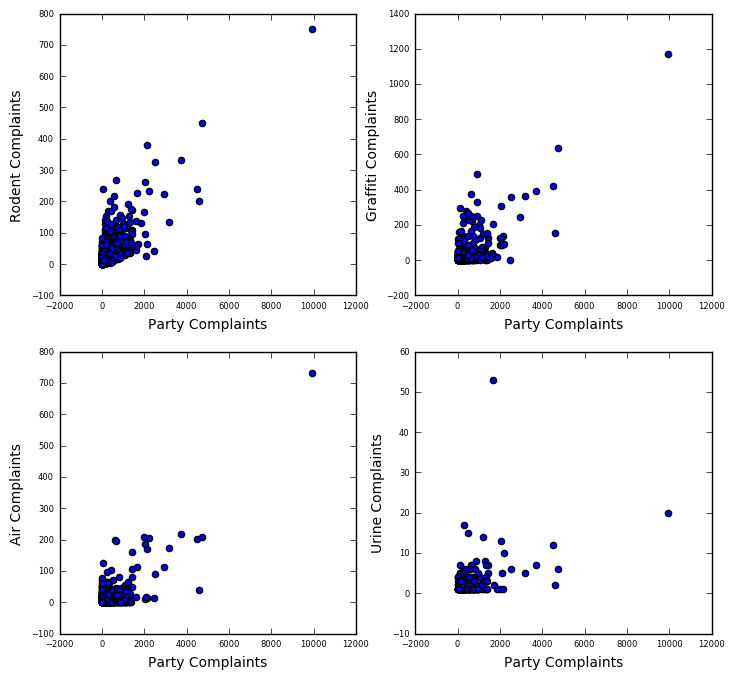

In [54]:
# Scatter plot of the party complaints and each input complaint. We look for outliers and visible correlation 

plt.subplot(2,3,1)
plt.scatter(newdf["Party Complaints"],newdf["Rodent Complaints"])
plt.xlabel("Party Complaints")
plt.ylabel("Rodent Complaints")
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)

plt.subplot(2,3,2)
plt.scatter(newdf["Party Complaints"],newdf["Graffiti Complaints"])
plt.xlabel("Party Complaints")
plt.ylabel("Graffiti Complaints")
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)

plt.subplot(2,3,4)
plt.scatter(newdf["Party Complaints"],newdf["Air Complaints"])
plt.xlabel("Party Complaints")
plt.ylabel("Air Complaints")
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)

plt.subplot(2,3,5)
plt.scatter(newdf["Party Complaints"],newdf["Urine Complaints"])
plt.xlabel("Party Complaints")
plt.ylabel("Urine Complaints")
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.show()

Note #1: Obviously there is one data point that is an outlier in all plots (in the top right corner). What is this?

Note #2: Also it is obvious that the vast majority of streets (i.e. data points) have #party complaints less than 2000.

We will consider if we should focus on these locations in order to avoid the most utter most loud party streets (where no.
of complaints exceed 2000 in 7 years ~ almost 1 per day.

In [55]:
# Identify the maximum value of the party complaints

newdf.loc[newdf['Party Complaints'].idxmax()]

Street Name            BROADWAY
Urine Complaints             20
Rodent Complaints           750
Graffiti Complaints        1172
Air Complaints              732
Party Complaints           9937
Total Complaints          12611
Name: 93, dtype: object

In [56]:
# A new cleaner dataset is created where we remove null observations, Broadway and streets with more than 2000 complaints

newerdf = newdf[newdf["Total Complaints"].notnull()] 
newerdf = newerdf[newerdf["Street Name"] != "BROADWAY"]
newerdf = newerdf[newerdf["Party Complaints"] < 2000]

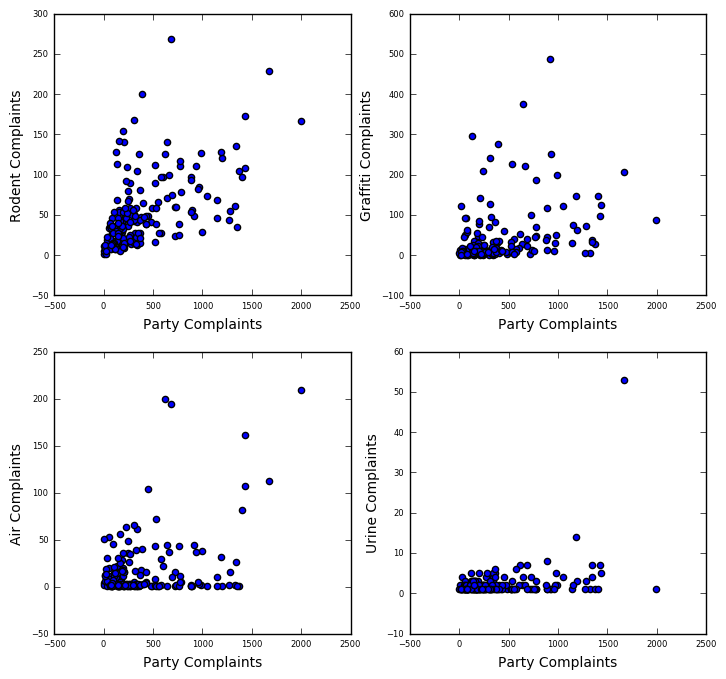

In [57]:
plt.subplot(2,3,1)
plt.scatter(newerdf["Party Complaints"],newerdf["Rodent Complaints"])
plt.xlabel("Party Complaints")
plt.ylabel("Rodent Complaints")
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)

plt.subplot(2,3,2)
plt.scatter(newerdf["Party Complaints"],newerdf["Graffiti Complaints"])
plt.xlabel("Party Complaints")
plt.ylabel("Graffiti Complaints")
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)

plt.subplot(2,3,4)
plt.scatter(newerdf["Party Complaints"],newerdf["Air Complaints"])
plt.xlabel("Party Complaints")
plt.ylabel("Air Complaints")
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)

plt.subplot(2,3,5)
plt.scatter(newerdf["Party Complaints"],newerdf["Urine Complaints"])
plt.xlabel("Party Complaints")
plt.ylabel("Urine Complaints")
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.show()

In [58]:
# Now we are ready for the linear regression (which is very easy with a pandas dataframe)

from pandas.stats.api import ols
res = ols(y=newerdf['Party Complaints'], x=newerdf[["Rodent Complaints", 
                                                    "Graffiti Complaints", "Air Complaints", "Urine Complaints"]])
print res

C:\Users\Luisa HP\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2881: FutureWarning: The pandas.stats.ols module is deprecated and will be removed in a future version. We refer to external packages like statsmodels, see some examples here: http://statsmodels.sourceforge.net/stable/regression.html
  exec(code_obj, self.user_global_ns, self.user_ns)



-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <Rodent Complaints> + <Graffiti Complaints> + <Air Complaints>
             + <Urine Complaints> + <intercept>

Number of Observations:         186
Number of Degrees of Freedom:   5

R-squared:         0.3608
Adj R-squared:     0.3467

Rmse:            309.4880

F-stat (4, 181):    25.5390, p-value:     0.0000

Degrees of Freedom: model 4, resid 181

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
Rodent Complaints     3.5009     0.6175       5.67     0.0000     2.2907     4.7112
Graffiti Complaints     0.9105     0.3507       2.60     0.0102     0.2231     1.5980
Air Complaints     1.1538     0.8159       1.41     0.1591    -0.4455     2.7530
Urine Complaints    10.0438     6.1641       1.63     0.1

**Conclusion of multiple linear regression:**

The p-values of the coefficients show that Rodent Complaints and Graffiti Complaints are significantly correlated with Party Complaints in a street (while Air Quality and Urinating in Public are not significant parameters).

Rodent Complaints has the highest correlation with party (coefficient of 3.5 compared to Graffiti = 0.9). This means that if we choose our location solely based on the number of parties, we will most likely encounter rodent issues and less likely graffiti issues.

However, the result suggests that we don't need to worry about having special problems with Air Quality and Public Urination, as these issues are not centred around the heavy party locations.

*A small p-value (typically ≤ 0.05) indicates strong evidence against the null hypothesis, so you reject the null hypothesis. By rejecting the null-hypothesis we work under the assumption that the coefficient is in fact significant in the model.*

**ATTEMPT TO CHANGE GEO CHOICE FROM STREET NAME TO ZIP CODE**

In [59]:
# How many zips names in New York?
# zip_dict was created in Section 3

print "No. of Zips in New York is", len(zip_dict.values())

No. of Zips in New York is 228


In [60]:
# Print New York zips
print "New York zips are:", zip_dict.keys()

New York zips are: [10271.0, 10278.0, 10279.0, 10280.0, 10281.0, 10282.0, 10803.0, 10301.0, 10302.0, 10303.0, 10304.0, 10305.0, 10306.0, 10307.0, 10308.0, 10309.0, 10310.0, 10312.0, 10314.0, 83.0, 11354.0, 11355.0, 11356.0, 11357.0, 11358.0, 11359.0, 11360.0, 11361.0, 11362.0, 11363.0, 11364.0, 11365.0, 11366.0, 11367.0, 11368.0, 11369.0, 11370.0, 11371.0, 11372.0, 11373.0, 11374.0, 11375.0, 11377.0, 11378.0, 11379.0, 11385.0, 10177.0, 11411.0, 11412.0, 11413.0, 11414.0, 11415.0, 11416.0, 11417.0, 11418.0, 11419.0, 11420.0, 11421.0, 11422.0, 11423.0, 10400.0, 11426.0, 11427.0, 11428.0, 11429.0, 11430.0, 11432.0, 11433.0, 11434.0, 11435.0, 11436.0, 11451.0, 11040.0, 11753.0, 10451.0, 10452.0, 10453.0, 10454.0, 10455.0, 10456.0, 10457.0, 10458.0, 10459.0, 10460.0, 10461.0, 10462.0, 10463.0, 10464.0, 10465.0, 10466.0, 10467.0, 10468.0, 10469.0, 10470.0, 10471.0, 10472.0, 10473.0, 10474.0, 10475.0, 11001.0, 11004.0, 11005.0, 10000.0, 10001.0, 10002.0, 10003.0, 10004.0, 10005.0, 10006.0, 10

In [62]:
print "The final dataset will consist of", len(zip_dict.values()), "rows, one for zip code in New York!"

The final dataset will consist of 228 rows, one for zip code in New York!


In [63]:
# Step 1: we split the full dataset into five subsets, so the number of incidents within each zip code can be counted

## Done in Setion 2 ##

In [68]:
# Step 2: we count the number of incidents within each zip code (by creating dictionaries)

zip_urine_dict = Counter(urine['Incident Zip'])
zip_rodent_dict = Counter(rodent['Incident Zip'])
zip_graffiti_dict = Counter(graffiti['Incident Zip'])
zip_air_dict = Counter(air['Incident Zip'])
zip_party_dict = Counter(party['Incident Zip'])

In [69]:
# Step 3: we convert the dictionaries into dataframes

zip_urine_df = pd.DataFrame(list(zip_urine_dict.iteritems()),columns=['Incident Zip','Urine Complaints'])
zip_rodent_df = pd.DataFrame(list(zip_rodent_dict.iteritems()),columns=['Incident Zip','Rodent Complaints'])
zip_graffiti_df = pd.DataFrame(list(zip_graffiti_dict.iteritems()),columns=['Incident Zip','Graffiti Complaints'])
zip_air_df = pd.DataFrame(list(zip_air_dict.iteritems()),columns=['Incident Zip','Air Complaints'])
zip_party_df = pd.DataFrame(list(zip_party_dict.iteritems()),columns=['Incident Zip','Party Complaints'])

In [70]:
# Step 4: we join the dataframes based on the zip codes
# Additionally we add a new column which is the sum of the complaints. 
# Later this column will be used to filter out observations with null values in any of the complaints (i.e. where the sum is null)

zip_newdf = pd.merge(zip_urine_df, zip_rodent_df, on='Incident Zip', how='outer')
zip_newdf = pd.merge(zip_newdf, zip_graffiti_df, on='Incident Zip', how='outer')
zip_newdf = pd.merge(zip_newdf, zip_air_df, on='Incident Zip', how='outer')
zip_newdf = pd.merge(zip_newdf, zip_party_df, on='Incident Zip', how='outer')
zip_newdf["Total Complaints"] = zip_newdf["Urine Complaints"] + zip_newdf["Rodent Complaints"] + zip_newdf["Air Complaints"] + zip_newdf["Graffiti Complaints"] + zip_newdf["Party Complaints"]

In [71]:
# Does the dataset look right?

zip_newdf[0:5]

Incident Zip  Urine Complaints  Rodent Complaints  Graffiti Complaints  \
0       10280.0               1.0               28.0                  NaN   
1       10301.0              11.0              880.0                147.0   
2       10302.0               9.0              604.0                167.0   
3       10303.0               6.0              796.0                169.0   
4       10304.0               8.0              861.0                224.0   

   Air Complaints  Party Complaints  Total Complaints  
0            65.0             147.0               NaN  
1           183.0            4087.0            5308.0  
2            90.0            2163.0            3033.0  
3            81.0            2250.0            3302.0  
4           107.0            4989.0            6189.0

**Section 5** Now the analysis part :-)

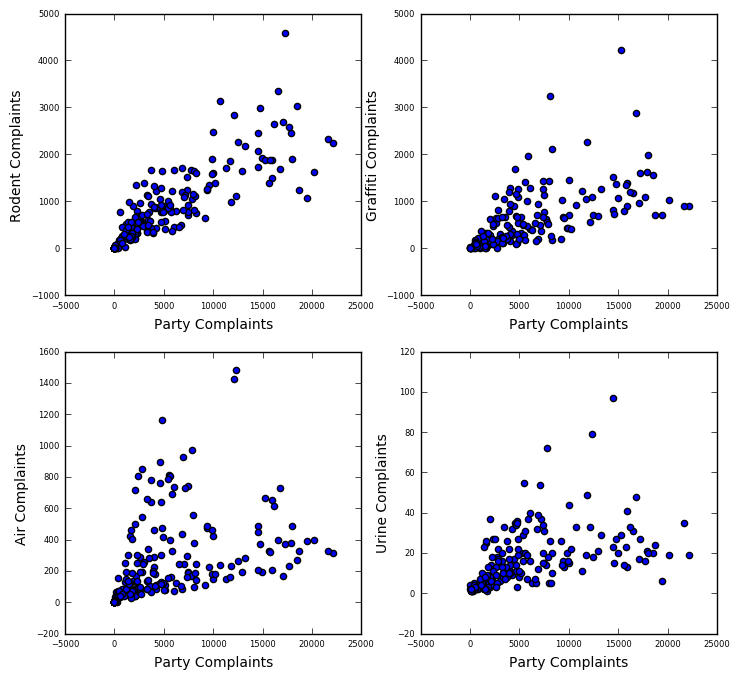

In [72]:
# Scatter plot of the party complaints and each input complaint. We look for outliers and visible correlation 

plt.subplot(2,3,1)
plt.scatter(zip_newdf["Party Complaints"],zip_newdf["Rodent Complaints"])
plt.xlabel("Party Complaints")
plt.ylabel("Rodent Complaints")
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)

plt.subplot(2,3,2)
plt.scatter(zip_newdf["Party Complaints"],zip_newdf["Graffiti Complaints"])
plt.xlabel("Party Complaints")
plt.ylabel("Graffiti Complaints")
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)

plt.subplot(2,3,4)
plt.scatter(zip_newdf["Party Complaints"],zip_newdf["Air Complaints"])
plt.xlabel("Party Complaints")
plt.ylabel("Air Complaints")
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)

plt.subplot(2,3,5)
plt.scatter(zip_newdf["Party Complaints"],zip_newdf["Urine Complaints"])
plt.xlabel("Party Complaints")
plt.ylabel("Urine Complaints")
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.show()

Note: We don't see any strange data points in the plots above that need to be further analised 

In [73]:
# Identify the maximum value of the party complaints

zip_newdf.loc[newdf['Party Complaints'].idxmax()]

Incident Zip           10012.0
Urine Complaints          20.0
Rodent Complaints        781.0
Graffiti Complaints     1435.0
Air Complaints           743.0
Party Complaints        7441.0
Total Complaints       10420.0
Name: 93, dtype: float64

The zip code with the maximum number of party complaints is 10012, which is lower Manhattan (SoHo)
http://www.zipmap.net/New_York.htm

In [74]:
# Now we are ready for the linear regression (which is very easy with a pandas dataframe)

from pandas.stats.api import ols
res = ols(y=zip_newdf['Party Complaints'], x=zip_newdf[["Rodent Complaints", 
                                                    "Graffiti Complaints", "Air Complaints", "Urine Complaints"]])
print res


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <Rodent Complaints> + <Graffiti Complaints> + <Air Complaints>
             + <Urine Complaints> + <intercept>

Number of Observations:         168
Number of Degrees of Freedom:   5

R-squared:         0.7010
Adj R-squared:     0.6936

Rmse:           2976.8277

F-stat (4, 163):    95.5155, p-value:     0.0000

Degrees of Freedom: model 4, resid 163

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
Rodent Complaints     4.6477     0.3659      12.70     0.0000     3.9305     5.3649
Graffiti Complaints     1.8892     0.4401       4.29     0.0000     1.0265     2.7518
Air Complaints    -0.6949     1.1428      -0.61     0.5440    -2.9349     1.5450
Urine Complaints    28.6675    22.2787       1.29     0.2

**Conclusion of multiple linear regression based on zip codes:**

The model's R-squared is MUCH higher than in the street model, other than that the conclusions are the same:

The p-values of the coefficients show that Rodent Complaints and Graffiti Complaints are significantly correlated with Party Complaints in a street (while Air Quality and Urinating in Public are not significant parameters).

Rodent Complaints has the highest correlation with party (coefficient of 4.6 compared to Graffiti = 1.9). This means that if we choose our location solely based on the number of parties, we will most likely encounter rodent issues and less likely graffiti issues.

However, the result suggests that we don't need to worry about having special problems with Air Quality and Public Urination, as these issues are not centred around the heavy party locations.

*A small p-value (typically ≤ 0.05) indicates strong evidence against the null hypothesis, so you reject the null hypothesis. By rejecting the null-hypothesis we work under the assumption that the coefficient is in fact significant in the model.*

In [82]:
# Based only on the multiple regression, we want to maximize party while minimizing rodents. 

# Find Top 10 party zip codes
top10_party = zip_newdf.nlargest(10, 'Party Complaints')

# Identify the minium value of the rodents
top10_party.loc[top10_party['Rodent Complaints'].idxmin()]

Incident Zip           10040.0
Urine Complaints           6.0
Rodent Complaints       1062.0
Graffiti Complaints      702.0
Air Complaints           394.0
Party Complaints       19490.0
Total Complaints       21654.0
Name: 120, dtype: float64

Preliminary conclusion: We want to place our bar in the zip code 10040